In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


In [2]:
file = "/Users/danichao/Documents/TimeSeriesData/LD2011_2014.txt"
data = pd.read_csv(file, sep = ';', index_col=0)

## Data Exploration

In [3]:
data.shape

(140256, 370)

In [4]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [5]:
data.iloc[0:96, 0] # A day includes 60/15*24=96 data points

2011-01-01 00:15:00    0
2011-01-01 00:30:00    0
2011-01-01 00:45:00    0
2011-01-01 01:00:00    0
2011-01-01 01:15:00    0
                      ..
2011-01-01 23:00:00    0
2011-01-01 23:15:00    0
2011-01-01 23:30:00    0
2011-01-01 23:45:00    0
2011-01-02 00:00:00    0
Name: MT_001, Length: 96, dtype: object

In [6]:
data.dtypes 

MT_001    object
MT_002    object
MT_003    object
MT_004    object
MT_005    object
           ...  
MT_366    object
MT_367    object
MT_368    object
MT_369    object
MT_370    object
Length: 370, dtype: object

There are 370 users, and I want to analysis only one user first (MT_001).

In [7]:
df_mt001 = data.loc[:, ['MT_001']]

In [8]:
df_mt001[(df_mt001.index > '2011-01-01 00:00:00') & (df_mt001.index < '2012-01-01 00:00:00')] # Data in 2011

,MT_001
2011-01-01 00:15:00,0
2011-01-01 00:30:00,0
2011-01-01 00:45:00,0
2011-01-01 01:00:00,0
2011-01-01 01:15:00,0
...,...
2011-12-31 22:45:00,0
2011-12-31 23:00:00,0
2011-12-31 23:15:00,0
2011-12-31 23:30:00,0


No MT_001 data in 2011

In [9]:
# Check 2012
df_mt001_2012 = df_mt001[(df_mt001.index > '2012-01-01 00:00:00') & (df_mt001.index < '2013-01-01 00:15:00')] 

In [10]:
df_mt001_2012

,MT_001
2012-01-01 00:15:00,"3,80710659898477"
2012-01-01 00:30:00,"5,0761421319797"
2012-01-01 00:45:00,"3,80710659898477"
2012-01-01 01:00:00,"3,80710659898477"
2012-01-01 01:15:00,"5,0761421319797"
...,...
2012-12-31 23:00:00,"2,53807106598985"
2012-12-31 23:15:00,"2,53807106598985"
2012-12-31 23:30:00,"1,26903553299492"
2012-12-31 23:45:00,"2,53807106598985"


MT_001 starts to have data from 2012

In [12]:
# Set the index to timestamp format
df_mt001_2012['time_date'] = pd.to_datetime(df_mt001_2012.index, utc=True)
df_mt001_2012.set_index('time_date', inplace=True)

In [18]:
# Include day-of-week and hour information for the "group by" later
df_mt001_2012['weekday'] = df_mt001_2012.index.dayofweek
df_mt001_2012['hour'] = df_mt001_2012.index.hour
df_mt001_2012['month'] = df_mt001_2012.index.month

In [19]:
df_mt001_2012

,MT_001,weekday,hour,month
time_date,,,,
2012-01-01 00:15:00+00:00,3.807107e+14,6,0,1
2012-01-01 00:30:00+00:00,5.076142e+13,6,0,1
2012-01-01 00:45:00+00:00,3.807107e+14,6,0,1
2012-01-01 01:00:00+00:00,3.807107e+14,6,1,1
2012-01-01 01:15:00+00:00,5.076142e+13,6,1,1
...,...,...,...,...
2012-12-31 23:00:00+00:00,2.538071e+14,0,23,12
2012-12-31 23:15:00+00:00,2.538071e+14,0,23,12
2012-12-31 23:30:00+00:00,1.269036e+14,0,23,12


We need to conver the number format - remove "," in the numbers 

In [16]:
def convert_data(data_arr):
    new = []

    for num in data_arr:
        if num != 0:
            temp = float(num.replace(',', ''))
        else:
            temp = num
        new.append(temp)
        
    return np.array(new)

In [17]:
intensity_001 = convert_data(df_mt001_2012['MT_001'].array[:])
df_mt001_2012['MT_001'] = intensity_001

<BarContainer object of 7 artists>

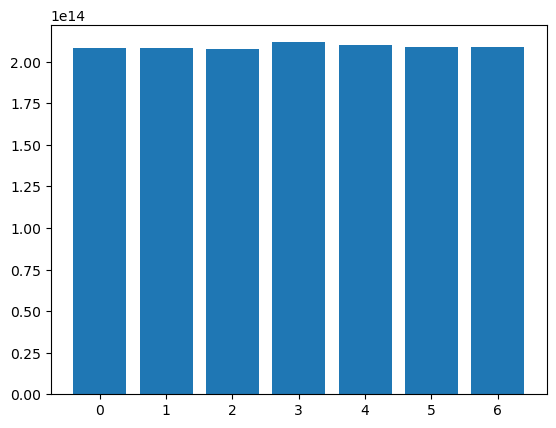

In [22]:
weekday_avg = df_mt001_2012.groupby(by = 'weekday')['MT_001'].mean()

fig = plt.figure()
plt.bar(weekday_avg.index, weekday_avg)

There is no special trend in week-day basis

<BarContainer object of 24 artists>

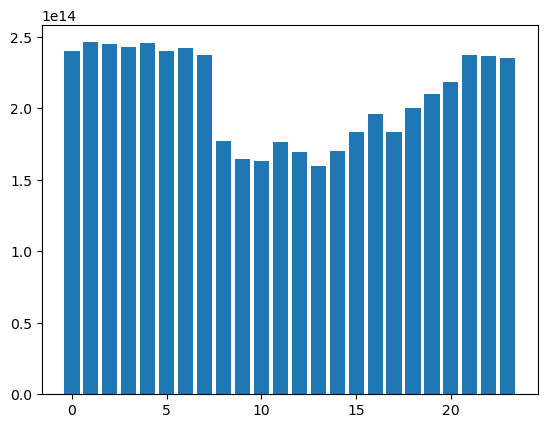

In [23]:
hour_avg = df_mt001_2012.groupby(by = 'hour')['MT_001'].mean()

fig = plt.figure()
plt.bar(hour_avg.index, hour_avg)

There is a clear trend in hour basis. The electric use is lower during the day (0800 - 1700), and it is increasing during 1800 -2100. The peak of the electric use is during 2100 - 0700. This indicates that MT_001 is a home place for someone or a family.

<BarContainer object of 12 artists>

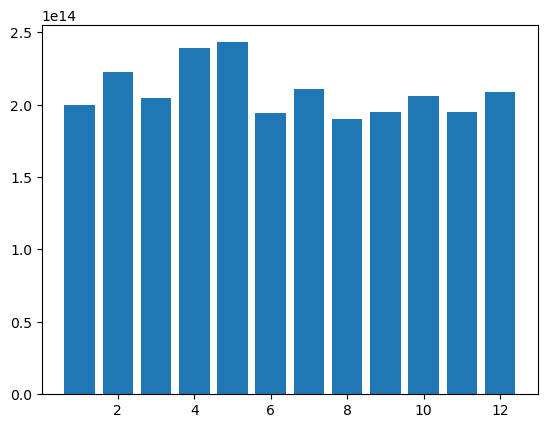

In [24]:
month_avg = df_mt001_2012.groupby(by = 'month')['MT_001'].mean()
fig = plt.figure()
plt.bar(month_avg.index, month_avg)

The people living in MT_001 probably stay at home a lot in February, April, and May. In Februray, it is probably because of the cold weather that they stay at home a lot and use electric heater; In April and May, it is probably the raining season in Portugal, so they also stay at home a lot. The lowest electric use is in August, which is quite reasonable that they probably go to somewhere for summer vacation.

# Preparation for time series fitting

Anaysis data in hour basis. (15 min is too short and too frequent for our purpose.)

In [25]:
data_in_hour = df_mt001_2012.resample('1H').sum()

In [26]:
data_in_hour

,MT_001,weekday,hour,month
time_date,,,,
2012-01-01 00:00:00+00:00,8.121827e+14,18,0,3
2012-01-01 01:00:00+00:00,1.192893e+15,24,4,4
2012-01-01 02:00:00+00:00,1.446701e+15,24,8,4
2012-01-01 03:00:00+00:00,8.629442e+14,24,12,4
2012-01-01 04:00:00+00:00,5.329949e+14,24,16,4
...,...,...,...,...
2012-12-31 20:00:00+00:00,8.883249e+14,0,80,48
2012-12-31 21:00:00+00:00,8.883249e+14,0,84,48
2012-12-31 22:00:00+00:00,7.614213e+14,0,88,48


In [27]:
dt_mt_2012 = data_in_hour

<AxesSubplot:xlabel='time_date'>

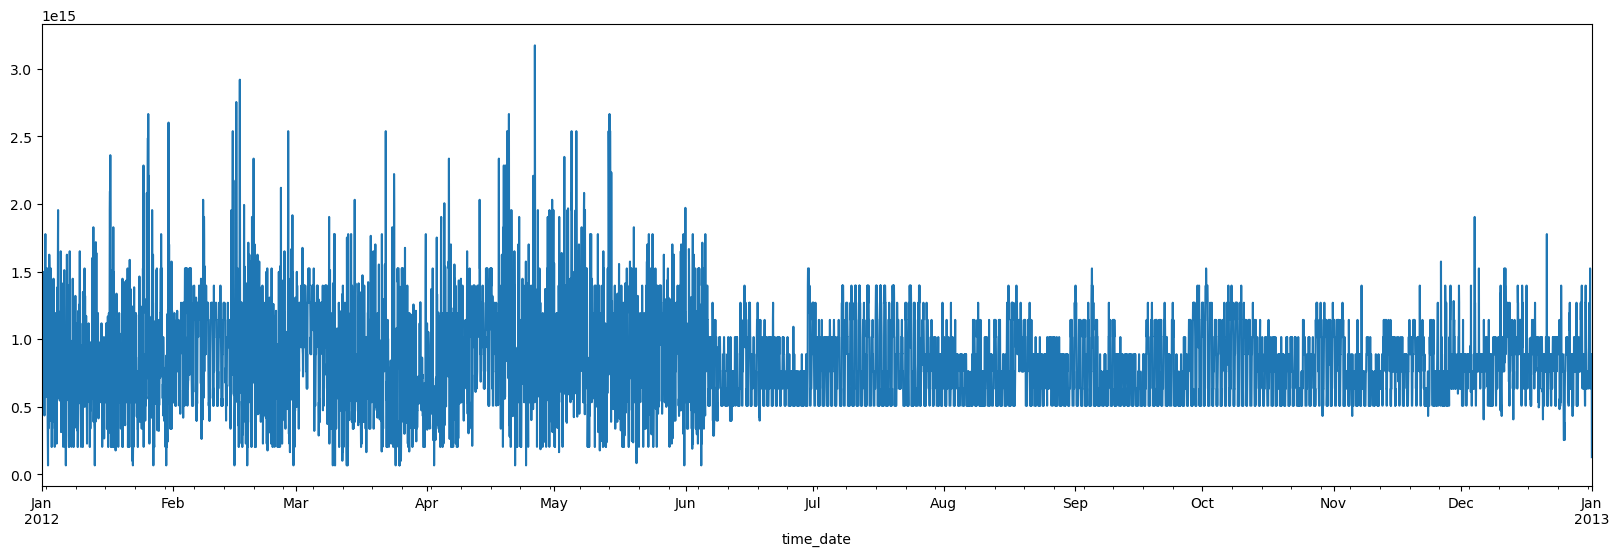

In [28]:
fig = plt.figure(figsize=(20,6))
dt_mt_2012['MT_001'].plot()

(It is a bit weird that electric use decrease after June all the way to the end of 2012. We need to check the electric use in 2013 and comapare to 2012 later.)

## Let's analyse only February first

In [29]:
data_feb = dt_mt_2012[(dt_mt_2012.index > '2012-01-31 23:00:00') & (dt_mt_2012.index < '2012-03-01 00:00:00')]

In [30]:
data_feb

,MT_001,weekday,hour,month
time_date,,,,
2012-02-01 00:00:00+00:00,5.329949e+14,8,0,8
2012-02-01 01:00:00+00:00,5.329949e+14,8,4,8
2012-02-01 02:00:00+00:00,8.629442e+14,8,8,8
2012-02-01 03:00:00+00:00,5.329949e+14,8,12,8
2012-02-01 04:00:00+00:00,5.329949e+14,8,16,8
...,...,...,...,...
2012-02-29 19:00:00+00:00,4.695431e+14,8,76,8
2012-02-29 20:00:00+00:00,8.629442e+14,8,80,8
2012-02-29 21:00:00+00:00,1.307107e+15,8,84,8


<AxesSubplot:xlabel='time_date'>

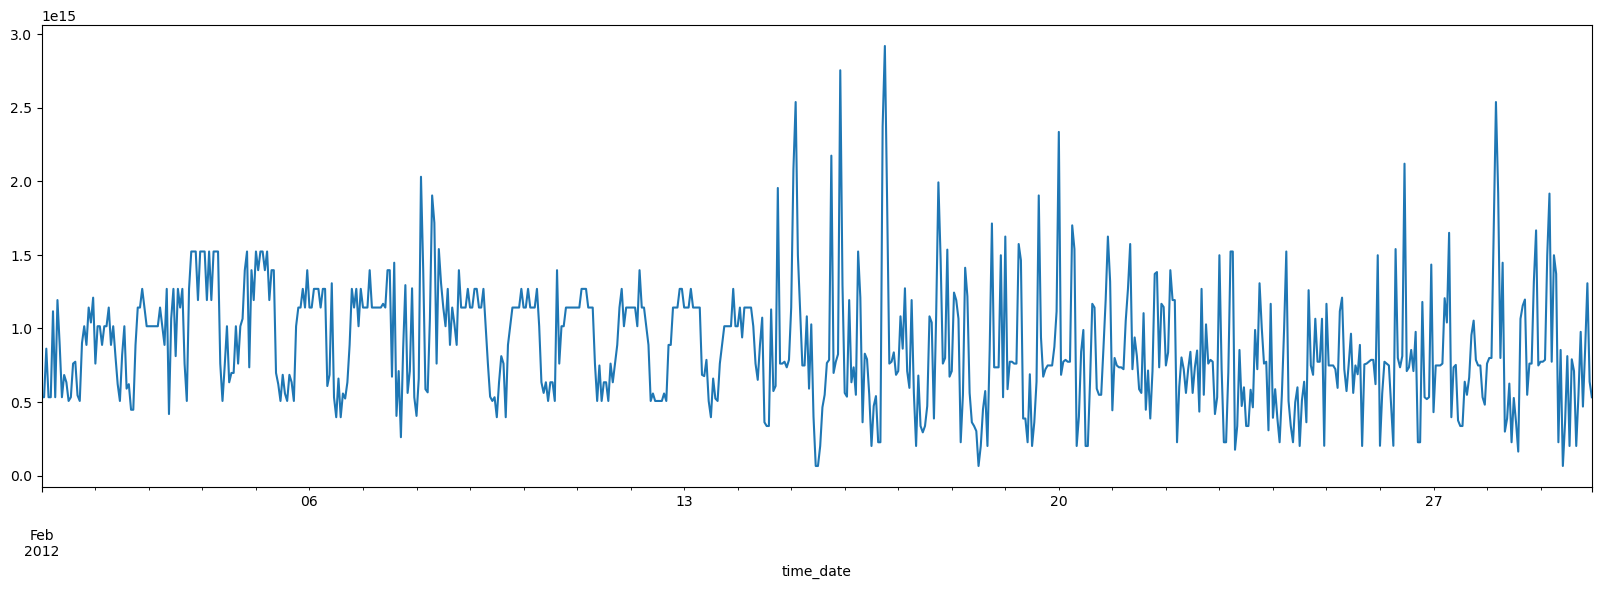

In [31]:
fig = plt.figure(figsize=(20,6))
data_feb['MT_001'].plot()

Although there are fluctuations, we can still see the electric use in February has some seasonality of "a day".

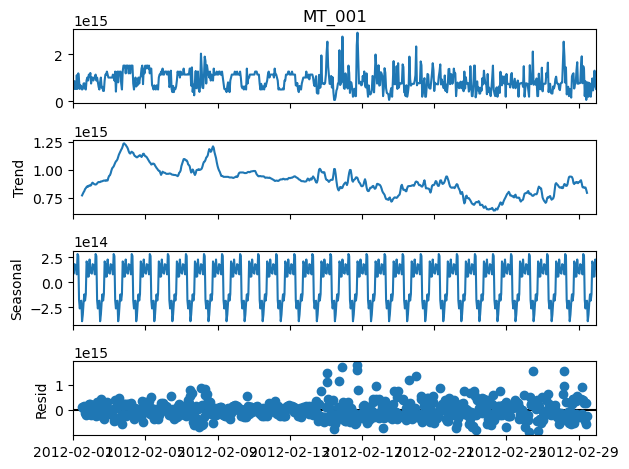

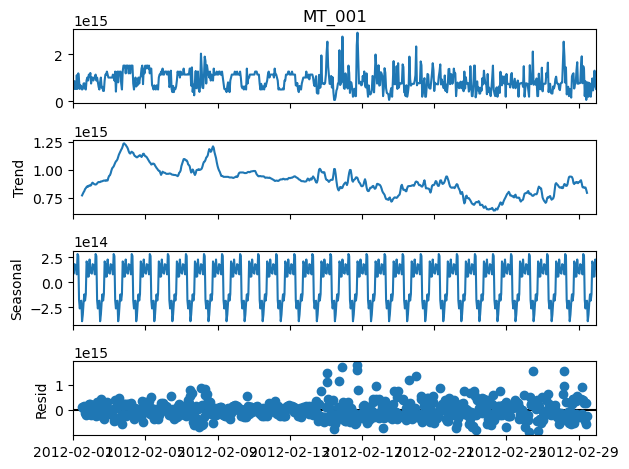

In [34]:
data_feb_decom = seasonal_decompose(data_feb['MT_001'], model='additive')

data_feb_decom.plot()

For the data in February, we can use a seasonal period of one day. Therefore, we will use an ARIMA model with a seaonal period of one day.

However, we should check the stationality of the time series (electric use) before we start fitting with ARIMA model. We use Augmented Dickey-Fuller test to see whether the time series or its one-step difference is stationary or not.

In [39]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_feb['MT_001'].values[1:])
print("-- Before taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

diff = data_feb['MT_001'].diff()
result = adfuller(diff.values[1:])
print("-- After taking the difference --")
print("ADF Statistic:", result[0])
print("p-value:", result[1])

-- Before taking the difference --
ADF Statistic: -0.661243927367095
p-value: 0.8565345175289738
-- After taking the difference --
ADF Statistic: -12.94298866554876
p-value: 3.5028103160685044e-24


Although the time series itself is not stationary (p-value > 0.05), its one-step difference is stationary, which implies that ARIMA model fitting should work well with p, q = 0 or 1 (first-order ARIMA model).   

In [35]:
# Fit with the first half, and predict the other half
int_past, int_future = data_feb['MT_001'][:336], data_feb['MT_001'][336:]

In [37]:
# Prepare for SARIMAX fitting. 
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # Pure ARIMA model parameter space
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in pdq] # SARIMA parameters; 24 is for that every 24 data points (24 hours) is a period

## Time series fitting

In [38]:

warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0)
best_model = None

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(int_past,
                          order = x1,
                          seasonal_order = x2,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = mod.fit()
            print("(p,d,q,P,D,Q,S) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58756D+01    |proj g|=  2.11842D-18

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.118D-18   3.588D+01
  F =   35.875588146215911     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 0, 0, 24): AIC = 24110.395234257092
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.97358D+01    |proj g|=  4.63203D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   4.632D-06   2.974D+01
  F =   29.735770723697627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 0, 1, 1, 24): AIC = 19986.437926324805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23602D+01    |proj g|=  4.51827D-05

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 0, 24): AIC = 20055.354055310134
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97557D+01    |proj g|=  2.79826D-01


 This problem is unconstrained.



At iterate    5    f=  2.97348D+01    |proj g|=  2.03816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   9.766D-07   2.973D+01
  F =   29.734413938491333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 0, 1, 1, 1, 24): AIC = 19987.526166666175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54931D+01    |proj g|=  2.28213D-01

At iterate    5    f=  3.54601D+01    |proj g|=  3.08845D-05

  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.95874D+01    |proj g|=  2.36252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.630D-06   2.959D+01
  F =   29.587445602470822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 0, 1, 1, 24): AIC = 19888.763444860393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29922D+01    |proj g|=  5.49799D-02

At iterate    5    f=  3.29851D+01    |proj g|=  5.26782D-05

  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   8.708D-06   2.980D+01
  F =   29.800112136546794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 0, 24): AIC = 20031.675355759446
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95964D+01    |proj g|=  1.17801D-01


 This problem is unconstrained.



At iterate    5    f=  2.95868D+01    |proj g|=  1.94114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   6.307D-06   2.959D+01
  F =   29.586837710794239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 0, 1, 1, 1, 1, 24): AIC = 19890.354941653728
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45874D+01    |proj g|=  1.91047D-17

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96518D+01    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   8.882D-08   2.965D+01
  F =   29.651760799899449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 0, 0, 1, 1, 24): AIC = 19929.98325753243
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22003D+01    |proj g|=  4.26326D-06

           * * *

Tit   = total number of iterations
Tnf   = tota

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (0, 1, 0, 1, 1, 0, 24): AIC = 20059.08678034549
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97138D+01    |proj g|=  1.06971D-01


 This problem is unconstrained.



At iterate    5    f=  2.96385D+01    |proj g|=  4.40903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     15      1     0     0   6.238D-06   2.964D+01
  F =   29.638486175866866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 0, 1, 1, 1, 24): AIC = 19923.062710182534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43801D+01    |proj g|=  5.15632D-02

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94344D+01    |proj g|=  1.22977D-01

At iterate    5    f=  2.94183D+01    |proj g|=  1.91779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   1.918D-05   2.942D+01
  F =   29.418292233033860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (0, 1, 1, 0, 1, 1, 24): AIC = 19775.092380598755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (0, 1, 1, 1, 0, 1, 24): AIC = 21409.195423615543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96967D+01    |proj g|=  4.74456D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point


 This problem is unconstrained.


Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   8.882D-08   2.969D+01
  F =   29.694939575301945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 1, 1, 1, 0, 24): AIC = 19960.999394602906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94715D+01    |proj g|=  6.09776D-02


 This problem is unconstrained.



At iterate    5    f=  2.94175D+01    |proj g|=  5.36673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     14      1     0     0   3.071D-06   2.942D+01
  F =   29.417470527925463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (0, 1, 1, 1, 1, 1, 24): AIC = 19776.540194765912
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46780D+01    |proj g|=  5.50287D-05

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96680D+01    |proj g|=  6.42397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.441D-08   2.967D+01
  F =   29.667989159292432     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 0, 0, 1, 1, 24): AIC = 19942.888715044515
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24681D+01    |proj g|=  7.23365D-01

At iterate    5    f=  3.22359D+01    |proj g|=  3.19023D-02

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96899D+01    |proj g|=  6.77649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   9.422D-07   2.968D+01
  F =   29.684648150591276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 0, 1, 1, 0, 24): AIC = 19954.083557197337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0       

 This problem is unconstrained.



At iterate    5    f=  2.96679D+01    |proj g|=  8.75907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   7.621D-06   2.967D+01
  F =   29.667767978891263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 0, 1, 1, 1, 24): AIC = 19944.74008181493
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44838D+01    |proj g|=  7.89802D-02

At iterate    5    f=  3.44807D+01    |proj g|=  2.96028D-04

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 0, 1, 0, 1, 0, 24): AIC = 21583.138753138075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95468D+01    |proj g|=  2.67080D-01


 This problem is unconstrained.



At iterate    5    f=  2.95044D+01    |proj g|=  7.85814D-02

At iterate   10    f=  2.95021D+01    |proj g|=  2.49712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.037D-05   2.950D+01
  F =   29.502068181942075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 0, 1, 0, 1, 1, 24): AIC = 19833.389818265074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23112D+01    |proj g|=  6.61295D-01

At

 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 0, 1, 1, 0, 1, 24): AIC = 21475.149191460543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96724D+01    |proj g|=  9.15206D-02


 This problem is unconstrained.



At iterate    5    f=  2.96658D+01    |proj g|=  9.70933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.952D-06   2.967D+01
  F =   29.665768046407390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 1, 1, 1, 0, 24): AIC = 19943.396127185766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95481D+01    |proj g|=  2.23383D-01


 This problem is unconstrained.



At iterate    5    f=  2.95135D+01    |proj g|=  1.41332D-01

At iterate   10    f=  2.95012D+01    |proj g|=  1.83091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.607D-06   2.950D+01
  F =   29.501206176769756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 0, 1, 1, 1, 1, 24): AIC = 19834.810550789276
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45247D+01    |proj g|=  5.63816D-06

  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.95948D+01    |proj g|=  2.00396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   2.333D-05   2.959D+01
  F =   29.594775333734290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 1, 0, 0, 1, 1, 24): AIC = 19893.689024269443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20374D+01    |proj g|=  5.79541D-02

           * * *

Tit   = total number of iterations
Tnf   = tot

 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 0, 1, 24): AIC = 21520.05654991905
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96702D+01    |proj g|=  6.10109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.300D-06   2.967D+01
  F =   29.670187217348566     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 1, 0, 24): AIC = 19944.365810058236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96477D+01    |proj g|=  8.90773D-02


 This problem is unconstrained.



At iterate    5    f=  2.95949D+01    |proj g|=  9.88010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     13      1     0     0   1.904D-05   2.959D+01
  F =   29.594765241145968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 1, 0, 1, 1, 1, 24): AIC = 19895.68224205009
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43781D+01    |proj g|=  2.60825D-02

At iterate    5    f=  3.43767D+01    |proj g|=  5.97623D-05

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


(p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 0, 24): AIC = 21533.910741028165
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94336D+01    |proj g|=  1.04322D-01


 This problem is unconstrained.



At iterate    5    f=  2.94151D+01    |proj g|=  5.29250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.994D-06   2.942D+01
  F =   29.415052401053192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 1, 24): AIC = 19774.915213507746
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19886D+01    |proj g|=  1.30893D-01

At iterate    5    f=  3.19738D+01    |proj g|=  3.57598D-03

  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.18460D+01    |proj g|=  4.07180D-02

At iterate   15    f=  3.18447D+01    |proj g|=  1.49666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   2.490D-05   3.184D+01
  F =   31.844733843794508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 1, 1, 1, 0, 1, 24): AIC = 21409.66114302991
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95898D+01    |proj g|=  5.42934D-02


 This problem is unconstrained.



At iterate    5    f=  2.95876D+01    |proj g|=  8.20569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   3.691D-06   2.959D+01
  F =   29.587582107266513     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(p,d,q,P,D,Q,S) = (1, 1, 1, 1, 1, 0, 24): AIC = 19890.855176083096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94694D+01    |proj g|=  7.17150D-02


 This problem is unconstrained.



At iterate    5    f=  2.94154D+01    |proj g|=  2.41139D-02

At iterate   10    f=  2.94142D+01    |proj g|=  2.94015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   2.940D-05   2.941D+01
  F =   29.414241689248779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
(p,d,q,P,D,Q,S) = (1, 1, 1, 1, 1, 1, 24): AIC = 19776.37041517518


In [40]:
print("Best (p,d,q,P,D,Q,S) =", param)

Best (p,d,q,P,D,Q,S) = (1, 1, 1, 0, 1, 1, 24)


In [41]:
results = best_model.fit()
results.summary().tables[1]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94336D+01    |proj g|=  1.04322D-01

At iterate    5    f=  2.94151D+01    |proj g|=  5.29250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   7.994D-06   2.942D+01
  F =   29.415052401053192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0698,0.097,0.717,0.473,-0.121,0.261
ma.L1,-0.7193,0.072,-9.957,0.000,-0.861,-0.578
ma.S.L24,-0.8187,0.057,-14.460,0.000,-0.930,-0.708
sigma2,1.088e+29,2.24e-31,4.86e+59,0.000,1.09e+29,1.09e+29


We can use ```plot_diagnostics``` to visualize the evaluation of the fitting result.

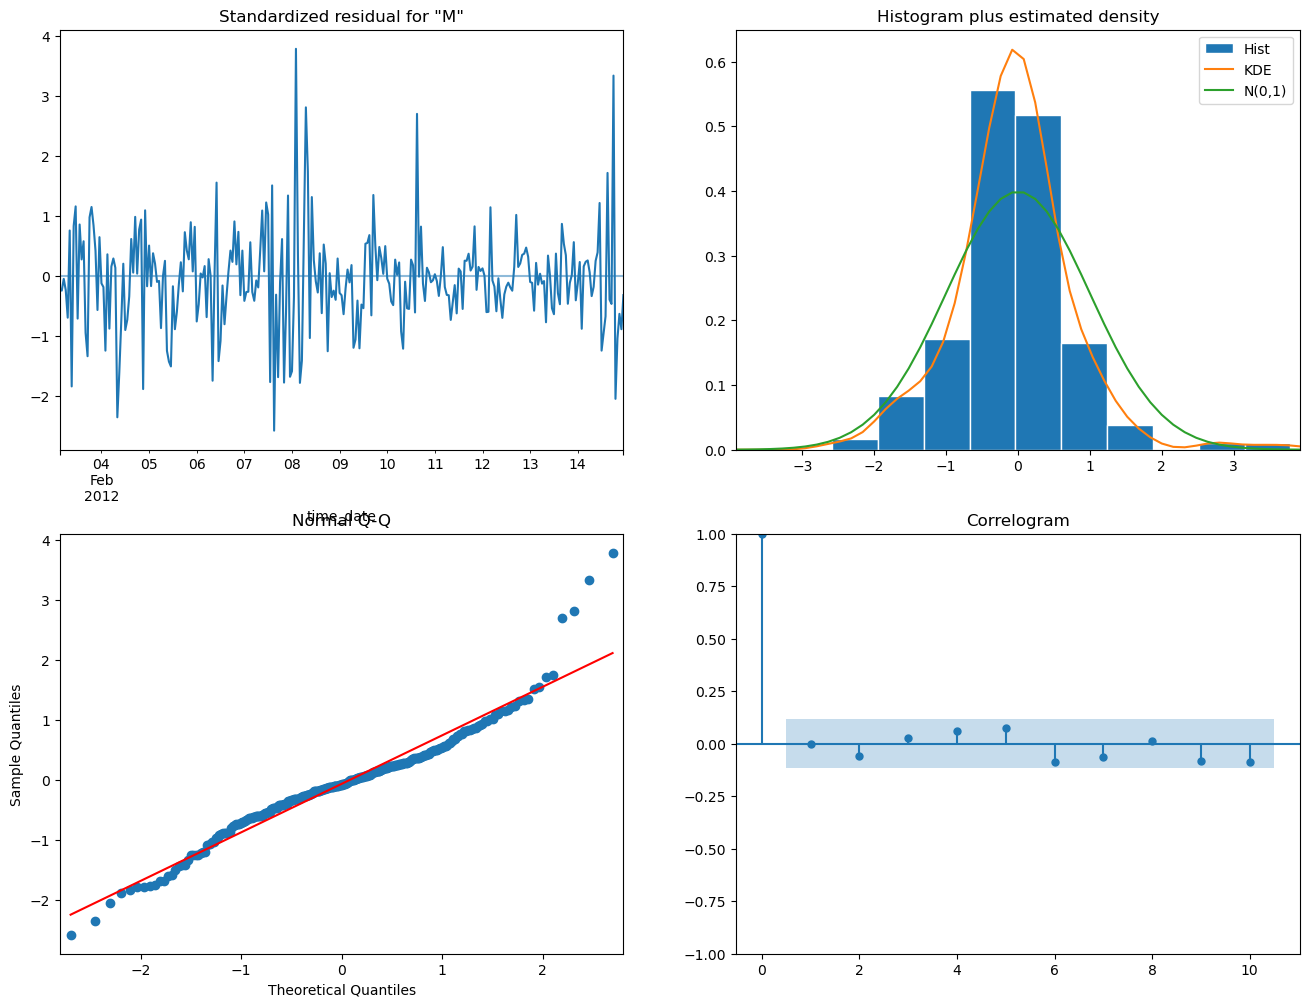

In [42]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

The fitting result seems not bad, as the residuals are close to normal distribution with mean equal to 0. The residuals also have no auto correlation.

# Let's see the fitting result and its prediction.

In [43]:
# in-sample prediction
pred = results.get_prediction(start = int_past['2012-02-02':].index[0],  dynamic=False)
pred_ci = pred.conf_int()

In [44]:
forecast = results.get_forecast(steps=360) # forecast for the rest February
forecast_ci = forecast.conf_int() # 95% confidence interval 

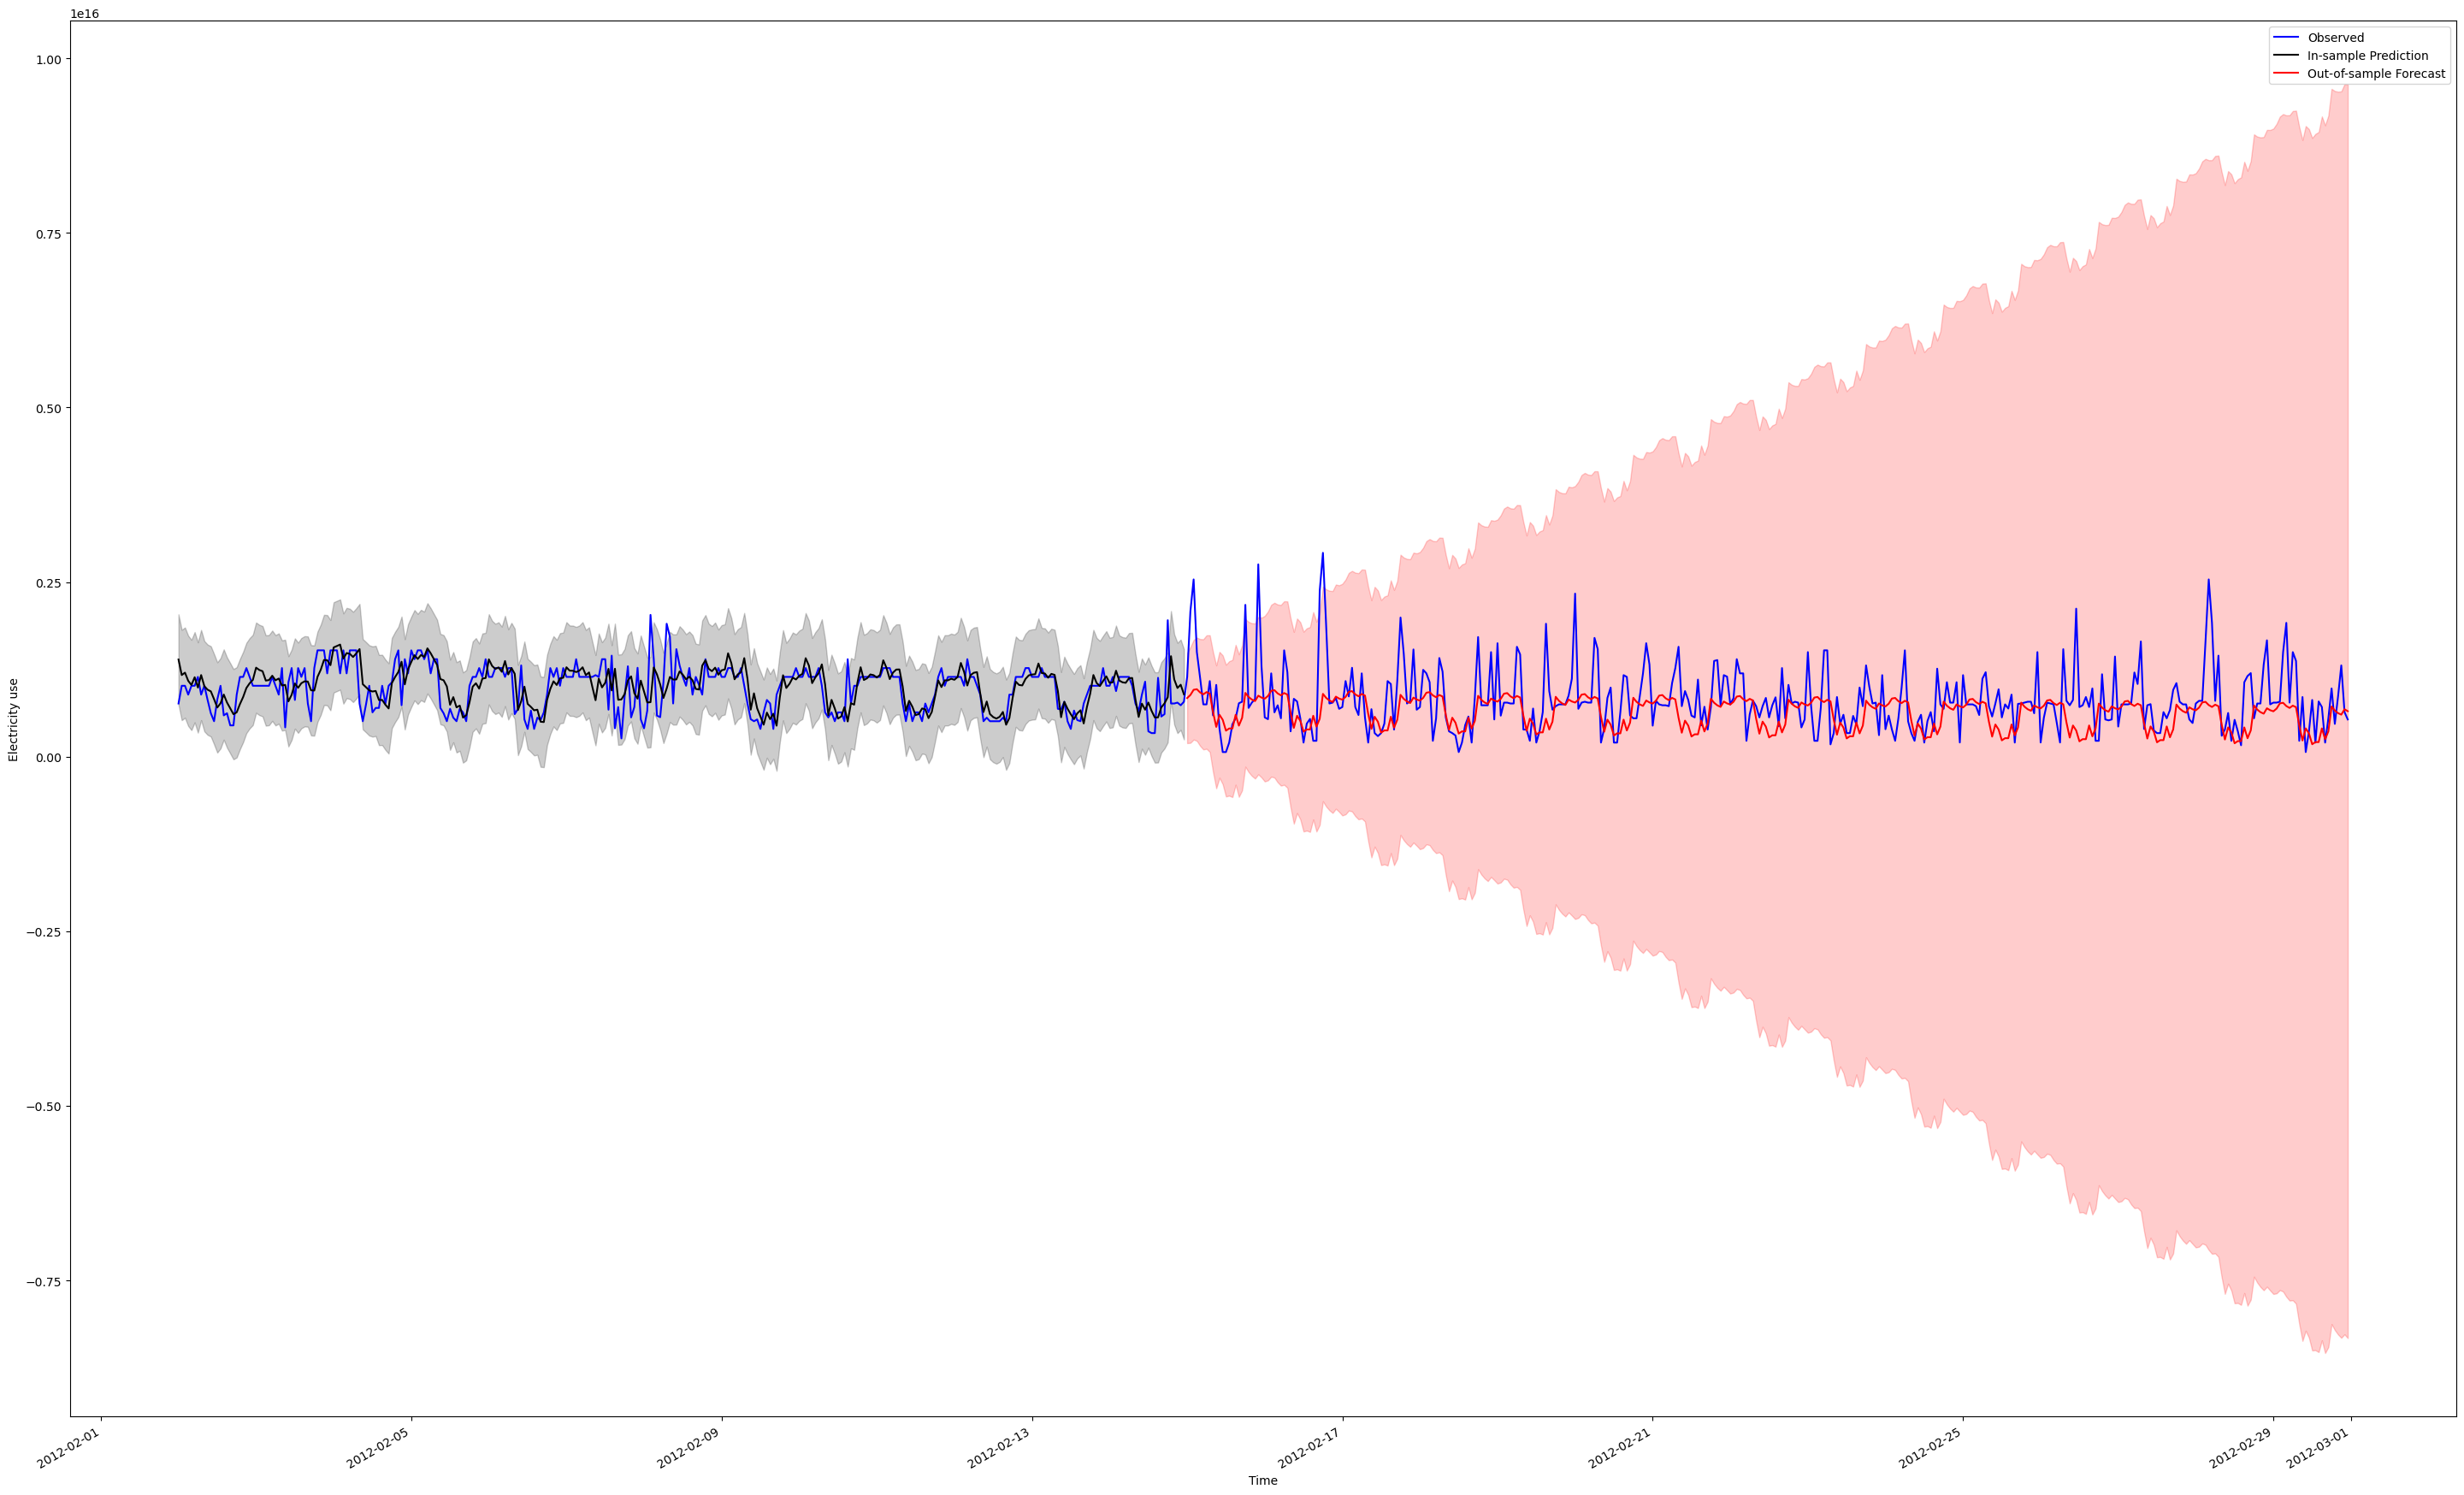

In [53]:
#plt.rcParams['figure.figsize'] = [36, 15]

fig, ax = plt.subplots(figsize=(36, 24))

ax.plot(data_feb['MT_001']['2012-02-02':].index, data_feb['MT_001']['2012-02-02':], label='Observed', color='b')

pred.predicted_mean.plot(ax=ax, label='In-sample Prediction', color='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

forecast.predicted_mean.plot(ax=ax, label='Out-of-sample Forecast', color='r')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Time')
ax.set_ylabel('Electricity use')
plt.legend()
plt.show()

Although there is discrepancy (between the observed and predicted values) and the 95%-confidence interval for the out-of sample is bizzare, the model still catch the overall trend of the time series well. Although the model can not describe the spikes very well, it still predict rises around the beginnings of spikes and downs around the ends of spikes.

### Prospects: 1. Use longer range of data in training/fitting to cover more weekends, where the spikes usually happen, and also predict a longer range of duration; 2. Use "a week/7 days" as fitting period, and also make prediction in weeks